In [2778]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Mean Utilization of Bicycles
The mean utilization of bicycle can give an indication of how far a growth potential with existing bicycles is still possible over time. In particular, the calculation in percent is therefore helpful.

In [2779]:
#Import data
trips = pd.read_parquet("../../data/bike_trips_cleaned.parquet")
trips.head(3)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,start_lon,end_lat,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip
index,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,-75.143749,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01,6.7,6.7,0.0
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,-75.149370,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01,6.7,6.7,0.0
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,-75.159952,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01,6.7,6.7,0.0


In [2780]:
#Reduce accuracy from date
trips['start_time_simplified'] = trips['start_time'].dt.floor('1H')
trips['end_time_simplified'] = trips['end_time'].dt.floor('1H')

In [2781]:
#Calculation of started and finished trips per hour
trips_starting = (trips.groupby(["start_time_simplified"]).size().to_frame("trips_starting"))
trips_ending = (trips.groupby(["end_time_simplified"]).size().to_frame("trips_ending"))

In [2782]:
#Combine DFs and fill empty values
trips_hourly = pd.concat([trips_starting, trips_ending], axis=1)
trips_hourly = trips_hourly.fillna(0)

In [2783]:
#Calculate difference of trips
trips_hourly['trips_diff'] = trips_hourly['trips_starting'] - trips_hourly['trips_ending']
trips_hourly['trips_active'] = trips_hourly['trips_diff'].cumsum()
trips_hourly['trips_prev_active'] = trips_hourly['trips_active'].shift(1)

In [2784]:
#Keep only relevant features
trips_hourly = trips_hourly[['trips_starting', 'trips_prev_active']]

In [2785]:
#Remove unavailable entries
trips_hourly = trips_hourly.dropna()

In [2786]:
#Add accuracy of the week in the year
trips['week'] = trips['start_time'].dt.isocalendar().week
bike_ids_week_grouped = (trips.groupby(["week"])['bike_id'].nunique().to_frame("bike_ids_week"))

In [2787]:
#Create a new DF that contains information about the first, last and number of trips based on the bikes.
bikes = trips.groupby("bike_id").agg({"start_time": "min","end_time": "max","bike_id": "count"})
bikes = bikes.rename(columns={"start_time" : "first_trip_start_time","end_time" : "last_trip_end_time","bike_id" : "number_of_trips"})

In [2788]:
#Decrease accuracy of time specification
bikes["start_time_simplified"] = bikes["first_trip_start_time"].dt.floor("1H")
bikes["end_time_simplified"] = bikes["last_trip_end_time"].dt.floor("1H") + pd.DateOffset(hours=1)
bikes_used_after = (bikes.groupby("start_time_simplified").size().to_frame("bikes_used_after"))
bikes_used_before = (bikes.groupby("end_time_simplified").size().to_frame("bikes_used_before"))

In [2789]:
#Combine DFs and fill NAs
bikes_used = pd.concat([bikes_used_before, bikes_used_after], axis=1)
bikes_used = bikes_used.fillna(0)
bikes_used['diff'] = bikes_used['bikes_used_after'] - bikes_used['bikes_used_before']
bikes_used['bikes_in_service'] = bikes_used['diff'].cumsum()

In [2790]:
#Match column name to content
bikes_used = bikes_used.reset_index().rename(columns={"index": "start_time_simplified"})

In [2791]:
#Add a new feature to smooth the edges
bikes_used["bikes_in_service_rolling"] = bikes_used.rolling("30d", center=True, on="start_time_simplified")["bikes_in_service"].max()

In [2792]:
#Fix index and fill NAs
bikes_used = bikes_used.set_index("start_time_simplified")
trips_hourly['bikes_in_service_rolling'] = bikes_used['bikes_in_service_rolling'].asfreq('1H', method="bfill")

In [2793]:
#Adjust DF with NAs fill, calculate missing times and hourly utilization
index_complete = pd.date_range(start='2016-01-01 01:00:00', end='2016-12-31 23:00:00', freq="H")
trips_hourly_adjusted = trips_hourly.reindex(index_complete, fill_value=np.nan).fillna(0)
trips_hourly_adjusted["utilization_absolute"]  =  trips_hourly_adjusted["trips_prev_active"]+ trips_hourly_adjusted["trips_starting"]
trips_hourly_adjusted["utilization_percentage"] = trips_hourly_adjusted["utilization_absolute"] / trips_hourly_adjusted["bikes_in_service_rolling"]

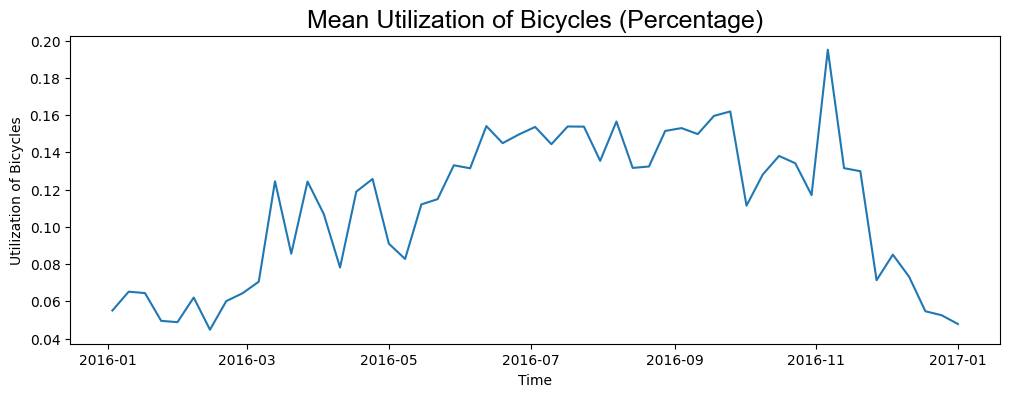

In [2794]:
#Displaying values graphically
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(trips_hourly_adjusted["utilization_percentage"].resample("w").mean())
ax.set_title("Mean Utilization of Bicycles (Percentage)", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bicycles")
plt.show()
#ax.figure.savefig("mean_utilization.png")

When looking at the utilization over time, it is noticeable that there are periodic increases and decreases in the utilization, which can possibly be assigned to the weekends, where the bicycle fleet is used more. Furthermore, there is an upswing in the summer months (May to September), whereas there is a decrease in the winter months.

It is noticeable that there is a peak in the first half of November with the maximum fleet utilization of the year. Possibilities for this would be holidays, events or also an unusual bicycle-friendly weather.

In [2795]:
#Import the data (part 1) and remove all unnecessary features and standardize the start time and start time
trips_hourly_stations_start = pd.read_parquet("../../data/bike_trips_cleaned.parquet")
data1 = trips_hourly_stations_start.drop(['bike_id','user_type','end_station_name','start_station_name','duration','start_lat','end_lat','end_lon','start_lon','distance','speed','average_time','date_time','max_temp','min_temp','precip','end_time','end_station_id'], axis=1)
data1.rename(columns={'start_time':'time','start_station_id':'station_id'}, inplace=True)
data1.head(5)

,time,station_id
index,,
0,2016-01-01 00:04:00,3046
1,2016-01-01 00:07:00,3028
2,2016-01-01 00:14:00,3007
3,2016-01-01 00:20:00,3045
4,2016-01-01 00:20:00,3005


In [2796]:
#Import the data (part 2) and remove all unnecessary features and standardize the end time and end station
trips_hourly_stations_end = pd.read_parquet("../../data/bike_trips_cleaned.parquet")
data2 = trips_hourly_stations_end.drop(['bike_id','user_type','end_station_name','start_station_name','duration','start_lat','end_lat','end_lon','start_lon','distance','speed','average_time','date_time','max_temp','min_temp','precip','start_time','start_station_id'], axis=1)
data2.rename(columns={'end_time':'time','end_station_id':'station_id'}, inplace=True)
data2.head(5)

,time,station_id
index,,
0,2016-01-01 00:14:00,3041
1,2016-01-01 00:29:00,3019
2,2016-01-01 00:27:00,3066
3,2016-01-01 00:30:00,3028
4,2016-01-01 00:42:00,3064


In [2797]:
#Merge both datasets into one
frames = [data1, data2]
trips_hourly_stations = pd.concat(frames)
trips_hourly_stations = trips_hourly_stations.reindex()

In [2798]:
#Calculation of the sum of all existing stations
sum_stations = trips_hourly_stations #Import data
sum_stations = sum_stations.drop(['time'], axis=1) #Feature Zeit entfernen
sum_stations = sum_stations.drop_duplicates() #Doppelte Einträge von Stationen entfernen
total_sum_stations = len(sum_stations.axes[0]) #Anzahl der Zeilen in Variable speichern

In [2799]:
#Reduction of accuracy from date, since representation is on daily basis
trips_hourly_stations['time'] = pd.to_datetime(trips_hourly_stations['time']).dt.date

In [2800]:
#Remove duplicate entries, as each station should be counted only once per day
trips_hourly_stations = trips_hourly_stations.drop_duplicates()

In [2801]:
#Group by date
trips_hourly_stations = trips_hourly_stations.groupby(['time']).count()

In [2802]:
#Converting used stations to unused stations
trips_hourly_stations['station_id'] = total_sum_stations - trips_hourly_stations['station_id']
trips_hourly_stations = trips_hourly_stations.rename({'station_id': 'unused_stations'}, axis=1)

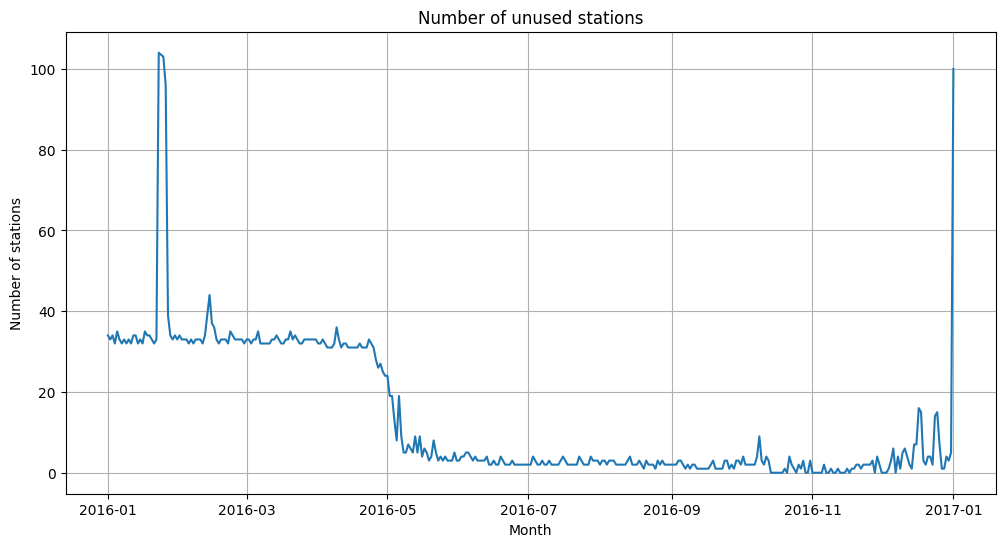

In [2803]:
#Displaying values graphically
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(trips_hourly_stations['unused_stations'])
ax.set_xlabel("Month")
ax.set_ylabel("Number of stations")
ax.set_title("Number of unused stations")
ax.grid()
plt.show()
#ax.figure.savefig("unused_stations.png")

When looking at the utilization over time, it is noticeable that there are no periodic increases and decreases. However, there is a significant reduction in unused stations at the change from April to May. Possible reasons for this could be a change in the number of stations and the opening of new ones.

It is noticeable that in the second half of January there is a peak with almost the total number of stations. Possibly there were weather-related restrictions, so that the stations were used only in a certain radius. At this point a more detailed analysis with reference to the location data would be an option. The peak at the end of the year can be explained by the fact that for January 2017 only the stations resulting from a trip started in 2016 were counted.

# Revenue with walk-up trips
In the following, the revenue of the trips of users who have a "walk-up" trip without a subscription will be calculated and presented over the course of the year. The cost for walk up users is 4 USD per started 30 minutes according to the information we could find from a flyer online (https://nacto.org/wp-content/uploads/2016/04/2015_Indego_Indego-Membership-and-Pricing_Brochure.pdf).

In [2804]:
#Read the data
revenue = pd.read_parquet("../../data/bike_trips_cleaned.parquet")
revenue.head(5)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,start_lon,end_lat,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip
index,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,-75.143749,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,6.7,0.0
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,-75.149370,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,6.7,0.0
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,-75.159952,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,6.7,0.0
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,-75.162361,39.940735,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,6.7,0.0
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,-75.144145,39.938280,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,7.2,0.0


In [2805]:
#Remove the features (columns) not needed for this calculation
revenue = revenue.drop(['end_station_id','bike_id','start_time','end_station_name','start_station_name','start_station_id','start_lat','end_lat','end_lon','start_lon','distance','speed','average_time','end_time','max_temp','min_temp','precip'], axis=1)

In [2806]:
#Reduce the accuracy from the timestamp to the date, since later to summarize the rows on the basis of the date
revenue['date_time'] = pd.to_datetime(revenue['date_time']).dt.date

In [2807]:
#Remove all non "walk-up" trips, as they are not observed
revenue = revenue.drop(revenue[revenue.user_type != 'Walk-up'].index)

In [2808]:
#Remove the user_type feature, because now all rows have the same one
revenue = revenue.drop(['user_type'], axis=1)

In [2809]:
#Recalculate duration in seconds to simplify later calculation
revenue['duration'] = revenue['duration'].dt.total_seconds()

In [2810]:
#Recalculation of the duration in revenue of the trip
revenue['duration'] = revenue['duration']/60 #Minutes
revenue['duration'] = revenue['duration']/30 #Cost interval of 30 minutes
revenue['duration'] = revenue['duration'].apply(np.ceil) #Started 30 minutes
revenue['duration'] = revenue['duration']*4 #4 USD per cost interval

In [2811]:
#Rename columns to match content
revenue = revenue.rename({'duration': 'revenue_usd', 'date_time': 'date'}, axis=1)

In [2812]:
#Group by sum per date for subsequent graphical representation
revenue = revenue.groupby(['date']).sum()

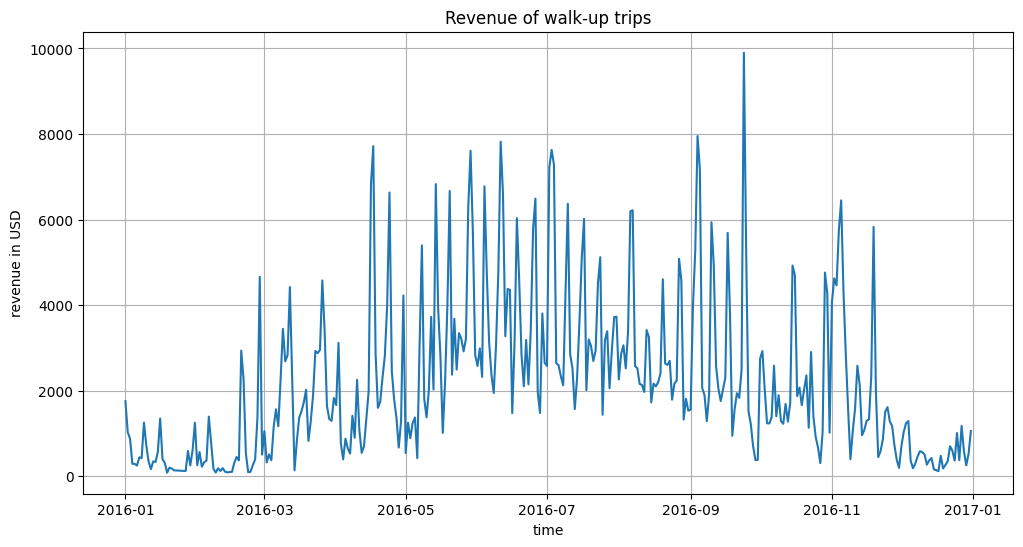

In [2813]:
#Displaying values graphically
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(revenue['revenue_usd'])
ax.set_xlabel("time")
ax.set_ylabel("revenue in USD")
ax.set_title("Revenue of walk-up trips")
ax.grid()
plt.show()
#ax.figure.savefig("revenue_walk_trips.png")

Looking at the utilization over time, we noticed that there are periodic increases and decreases in the revenues, which can possibly be attributed to the following points: Weekends where the bike fleet is used more and especially more spontaneous trips take place and trips are longer. Furthermore, there is a general upswing in the summer months (May to September), whereas there is a decrease in the winter months.

It is noticeable that there is a peak in the second half of September with the maximum fleet utilization of the year. Possibilities for this would be holidays, events or also an unusual bicycle-friendly weather.